In [1]:
import tensorflow as tf;
import tensorflow_datasets as tfds;
import matplotlib;
from matplotlib import pyplot as plt;
import seaborn as sns

from tensorflow.keras.callbacks import TensorBoard
import datetime

# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

2024-10-06 23:01:04.241309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 23:01:04.372824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 23:01:04.412359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 23:01:04.677013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 23:01:07.761592: W tensorflow/compiler/tf2

In [2]:
print( tf.__version__ )

2.17.0


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


I0000 00:00:1728270072.561137   12144 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-06 23:01:12.948033: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
train_data, val_data, test_data = tfds.load( "mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True )

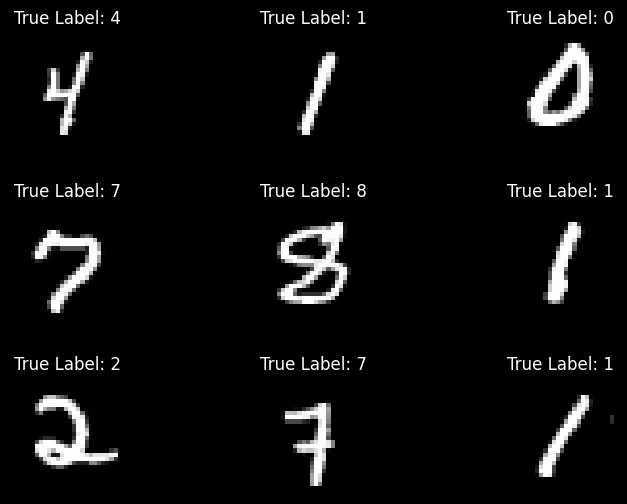

In [5]:
x_viz, y_viz = tfds.load( "mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True )[0]
x_viz = tf.squeeze( x_viz, axis=3 )

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

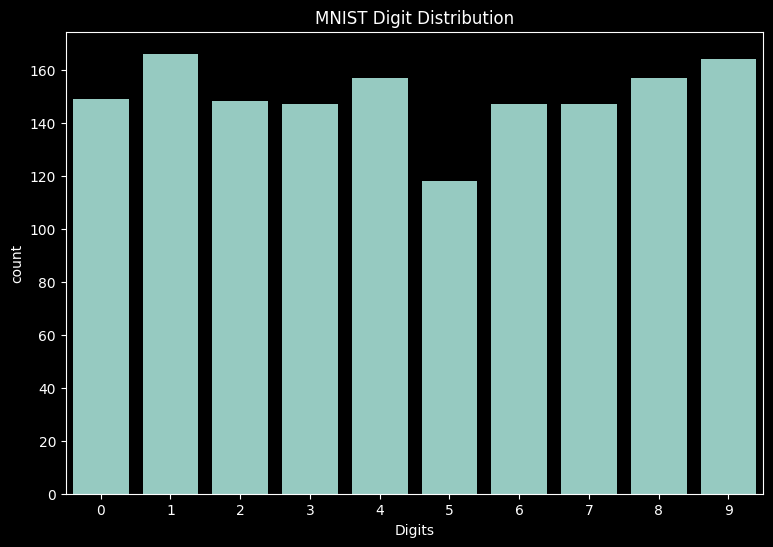

In [6]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [7]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [8]:
def xavier_init( shape ):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape;
  xavier_lim = tf.sqrt( 6. )/tf.sqrt( tf.cast( in_dim + out_dim, tf.float32 ) );
  weight_vals = tf.random.uniform( shape=( in_dim, out_dim ), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22 );
  return weight_vals;

In [9]:
class DenseLayer( tf.Module ):
    """
    """
    def __init__( self, out_dim, weight_init=xavier_init, activation=tf.identity ):
        """
        """
        self.out_dim = out_dim;
        self.weight_init = weight_init;
        self.activation = activation;
        self.built = False;

    def __call__( self, x ):
        """
        """
        if not self.built:
            self.in_dim = x.shape[1];
            self.W = tf.Variable( self.weight_init( shape = (self.in_dim, self.out_dim) ) );
            self.b = tf.Variable( tf.zeros( shape = (self.out_dim,) ) );
            self.built = True;

        intermediate = tf.add( tf.matmul ( x, self.W ), self.b );
        return self.activation( intermediate );


In [10]:
class MLP( tf.Module ):
    """
    """
    def __init__( self, layers ):
        """
        """
        self.layers = layers;

    @tf.function
    def __call__( self, x, preds=False ):
        """
        """
        for layer in self.layers:
            x = layer( x );
        return x;

In [11]:
def cross_entropy_loss( y_pred, y ):
    """
    """
    sparse_categorical_crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits( labels=y, logits=y_pred );
    return tf.reduce_mean( sparse_categorical_crossentropy );

In [12]:
def accuracy( y_pred, y ):
    """
    """
    class_preds = tf.argmax( tf.nn.softmax( y_pred ), axis=1 );
    is_equal = tf.equal( y, class_preds );
    return tf.reduce_mean( tf.cast( is_equal, tf.float32 ) );

In [13]:
class GradientDesent( tf.Module ):
    """
    """
    def __init__( self, learning_rate ):
        """
        """
        self.learning_rate = learning_rate;
        self.title = f"Gradient Descent Optimizer: learning rate = {self.learning_rate}";

    def apply_gradients( self, grads, vars ):
        """
        """
        for grad, var in zip( grads, vars ):
            var.assign_sub( self.learning_rate * grad );

In [14]:
def train_step( x_batch, y_batch, lss, acc, model, optimizer ):
    """
    """
    with tf.GradientTape() as tape:
        y_pred = model( x_batch );
        loss = lss( y_pred, y_batch );
    grads = tape.gradient( loss, model.trainable_variables );
    optimizer.apply_gradients( grads, model.trainable_variables );
    return loss, acc( y_pred, y_batch );

def val_step( x_batch, y_batch, loss, acc, model ):
    """
    """
    y_pred = model( x_batch );
    batch_loss = loss( y_pred, y_batch );
    batch_acc = acc( y_pred, y_batch );
    return batch_loss, batch_acc;

In [15]:
def train_model( mlp, train_data, val_data, loss, acc, optimizer, epochs, callbacks ):
    tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir="logs" );
    train_losses, train_accs = [], [];
    val_losses, val_accs = [], [];

    for epoch in range( epochs ):
        batch_losses_train, batch_accs = [], [];
        batch_losses_val, batch_accs_val = [], [];

        for x_batch, y_batch in train_data:
            batch_loss, batch_acc = train_step( x_batch, y_batch, loss, acc, mlp, optimizer );
            batch_losses_train.append( batch_loss );
            batch_accs.append( batch_acc );
            tensorboard_callback.on_batch_end( epoch, {"batch_loss": batch_loss, "batch_accuracy": batch_acc} );

        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step( x_batch, y_batch, loss, acc, mlp );
            batch_losses_val.append( batch_loss );
            batch_accs_val.append( batch_acc );
            tensorboard_callback.on_batch_end( epoch, {"val_loss": batch_loss, "val_accuracy": batch_acc} );

        # keep track of epoch level model performances
        train_loss, train_acc = tf.reduce_mean( batch_losses_train ), tf.reduce_mean( batch_accs );
        val_loss, val_acc = tf.reduce_mean( batch_losses_val ), tf.reduce_mean( batch_accs_val );
        train_losses.append( train_loss );
        train_accs.append( train_acc );
        val_losses.append( val_loss );
        val_accs.append( val_acc );
        print(f"Epoch: {epoch}" );
        print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}");
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}");

      
    return train_losses, train_accs, val_losses, val_accs;

In [16]:
hidden_layer_1_size = 784
#hidden_layer_2_size = 500
output_size = 10
learning_rate = 0.01

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    #DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [17]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=GradientDesent(learning_rate), epochs=10, callbacks=[tensorboard_callback] )

2024-10-06 23:01:18.904992: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-06 23:01:19.507218: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 0
Train Loss: 1.1413824558258057, Train Accuracy: 0.7688938975334167
Validation Loss: 0.6637558937072754, Validation Accuracy: 0.856210470199585


2024-10-06 23:01:22.756155: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 1
Train Loss: 0.5532960891723633, Train Accuracy: 0.8698649406433105
Validation Loss: 0.4775114357471466, Validation Accuracy: 0.8824169039726257
Epoch: 2
Train Loss: 0.44111168384552, Train Accuracy: 0.8868086934089661
Validation Loss: 0.40826642513275146, Validation Accuracy: 0.894382894039154


2024-10-06 23:01:29.634513: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 3
Train Loss: 0.38994958996772766, Train Accuracy: 0.8959878087043762
Validation Loss: 0.3700546622276306, Validation Accuracy: 0.9011076092720032
Epoch: 4
Train Loss: 0.35877156257629395, Train Accuracy: 0.902461588382721
Validation Loss: 0.34470075368881226, Validation Accuracy: 0.9076344966888428
Epoch: 5
Train Loss: 0.33676186203956604, Train Accuracy: 0.9070891737937927
Validation Loss: 0.32597795128822327, Validation Accuracy: 0.9112935066223145
Epoch: 6
Train Loss: 0.3198007345199585, Train Accuracy: 0.9114649891853333
Validation Loss: 0.31120243668556213, Validation Accuracy: 0.9153481125831604


2024-10-06 23:01:45.549851: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 7
Train Loss: 0.3059678375720978, Train Accuracy: 0.914941668510437
Validation Loss: 0.2989645004272461, Validation Accuracy: 0.9190071225166321
Epoch: 8
Train Loss: 0.29423150420188904, Train Accuracy: 0.9183223843574524
Validation Loss: 0.28848907351493835, Validation Accuracy: 0.9207871556282043
Epoch: 9
Train Loss: 0.28400465846061707, Train Accuracy: 0.9215592741966248
Validation Loss: 0.2793516218662262, Validation Accuracy: 0.9232594966888428


In [18]:
def plot_metrics( train_metric, val_metric, metric_type ):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot( range( len( train_metric ) ), train_metric, label = f"Training {metric_type}" )
  plt.plot( range( len( val_metric ) ), val_metric, label = f"Validation {metric_type}" )
  plt.xlabel( "Epochs" )
  plt.ylabel( metric_type )
  plt.legend()
  plt.title( f"{metric_type} vs Training epochs" );

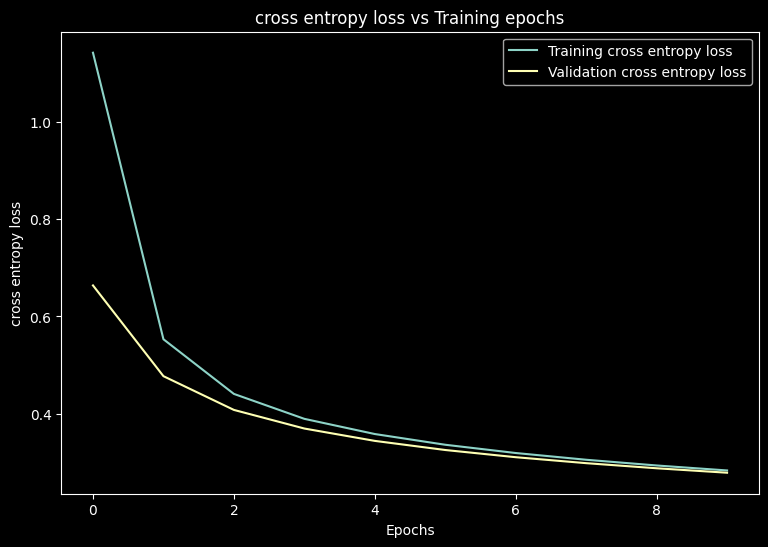

In [19]:
plot_metrics( train_losses, val_losses, "cross entropy loss" )

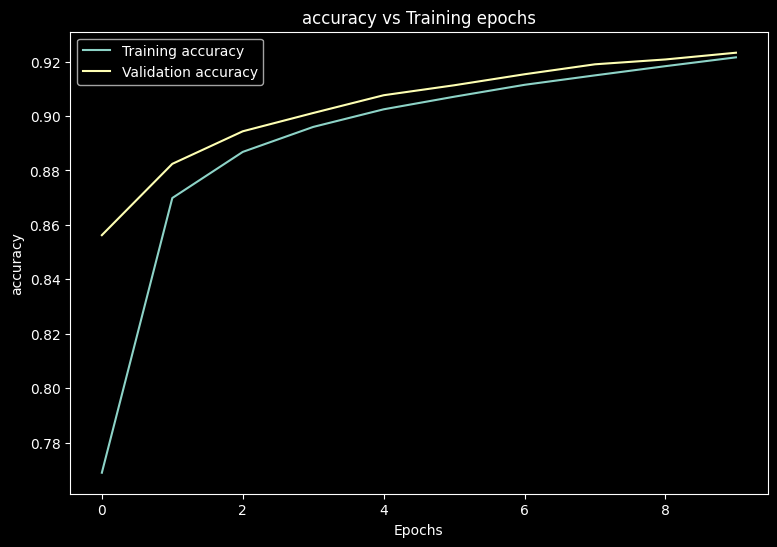

In [20]:
plot_metrics( train_accs, val_accs, "accuracy" )